In [1]:
# === SETUP (run this FIRST) ===
# Upgrade core libs (fixes the pyarrow/datasets ImportWarning you faced)
!pip install --upgrade pip --quiet
!pip install --upgrade "pyarrow>=8.0.0" "fsspec>=2021.6.0" --quiet

# Stable, widely-used HF stack
!pip install "transformers>=4.37,<5" "datasets>=2.14" "accelerate>=0.25" "evaluate>=0.4" --quiet

# (Optional) W&B for experiment tracking; safe to leave installed even if unused
!pip install wandb --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platf

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

print("Transformers version:", __import__("transformers").__version__)
print("Datasets version:", __import__("datasets").__version__)
print("Evaluate version:", evaluate.__version__)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2025-08-26 22:31:59.002616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756247519.218757      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756247519.289401      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers version: 4.52.4
Datasets version: 3.6.0
Evaluate version: 0.4.5
PyTorch: 2.6.0+cu124
CUDA available: True


In [3]:
# You can switch to 'bert-base-uncased' if you want the full BERT
MODEL_NAME = "bert-base-uncased"   # or "distilbert-base-uncased"
TASK_NAME  = "imdb-bert-finetune"
SEED       = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# (Optional) Enable/disable Weights & Biases logging
# - To log: set WANDB_MODE="online" and replace YOUR_WANDB_PROJECT with your project name.
# - To disable completely: set WANDB_DISABLED="true".
os.environ["WANDB_DISABLED"] = "true"           # disable by default
# os.environ["WANDB_MODE"] = "online"
# os.environ["WANDB_PROJECT"] = "YOUR_WANDB_PROJECT"


In [4]:
# Loads the standard IMDB sentiment dataset (train/test), labels: 0=neg, 1=pos
dataset = load_dataset("imdb")
print(dataset)
print(dataset["train"][0])


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    # Truncate/pad to a reasonable length for BERT
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,      # padding handled later by data collator
        max_length=256
    )

tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")

# For Trainer: set format as torch tensors
tokenized.set_format(type="torch")
print(tokenized)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [7]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"./{TASK_NAME}-outputs",
    do_train=True,
    do_eval=True,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],   # IMDB has no dev set; we eval on test here
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/1708855464.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
train_result = trainer.train()
trainer.save_model()  # saves model + tokenizer to output_dir
train_result


Step,Training Loss
100,0.484200
200,0.304200
300,0.316000
400,0.260600
500,0.265800
600,0.265200
700,0.277000
800,0.243900
900,0.236200
1000,0.279100


TrainOutput(global_step=4689, training_loss=0.17141953407510507, metrics={'train_runtime': 2051.1857, 'train_samples_per_second': 36.564, 'train_steps_per_second': 2.286, 'total_flos': 9866631687118080.0, 'train_loss': 0.17141953407510507, 'epoch': 3.0})

In [11]:
eval_metrics = trainer.evaluate()
eval_metrics


{'eval_loss': 0.32581424713134766,
 'eval_accuracy': 0.92388,
 'eval_f1': 0.923879386041576,
 'eval_runtime': 182.0453,
 'eval_samples_per_second': 137.328,
 'eval_steps_per_second': 8.586,
 'epoch': 3.0}

In [12]:
# Save the *best* model (already in output_dir due to load_best_model_at_end)
save_dir = f"./{TASK_NAME}-best"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Saved to:", save_dir)


Saved to: ./imdb-bert-finetune-best


Accuracy: 0.9239
Weighted F1: 0.9239

Classification report:
              precision    recall  f1-score   support

           0     0.9215    0.9267    0.9241     12500
           1     0.9263    0.9210    0.9237     12500

    accuracy                         0.9239     25000
   macro avg     0.9239    0.9239    0.9239     25000
weighted avg     0.9239    0.9239    0.9239     25000


Confusion matrix (counts):
        pred_0  pred_1
true_0   11584     916
true_1     987   11513


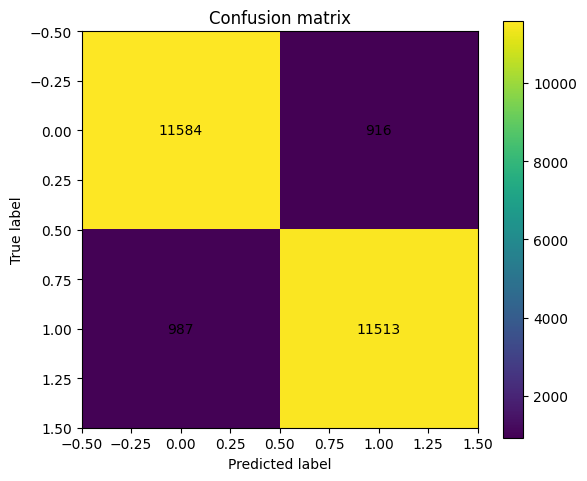

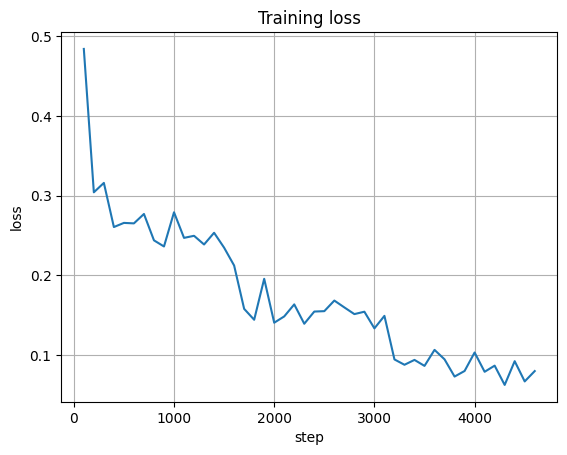

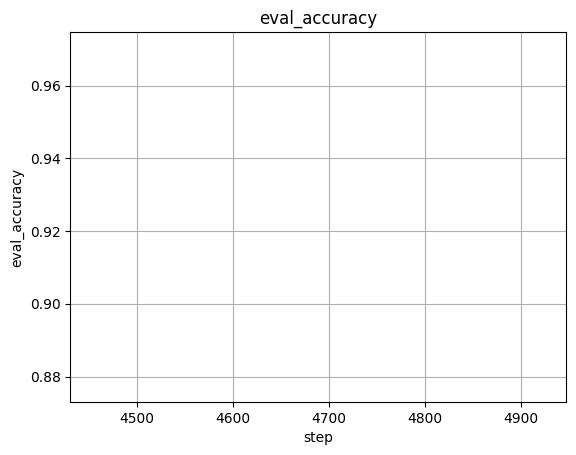

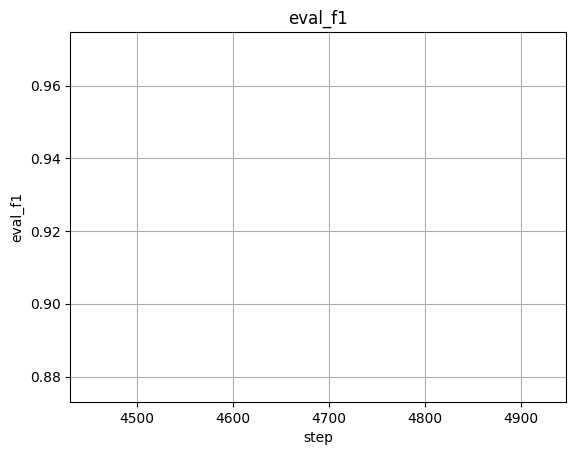

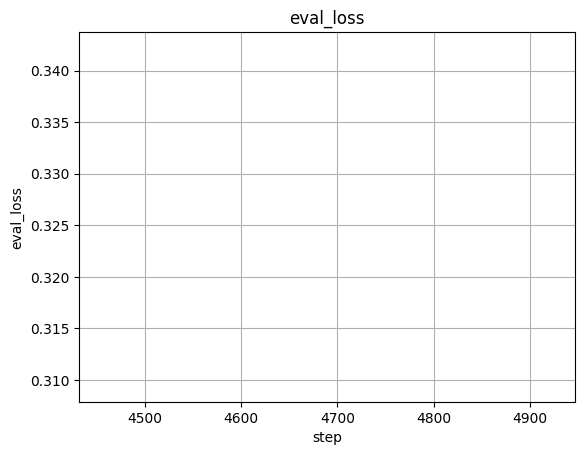


Saved confusion_matrix.csv in the working directory.


In [13]:
# === FINAL PERFORMANCE / METRICS CELL ===
# Paste this as the final cell after training/evaluation.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Optional: limit number of test examples to speed up prediction (None = use full test set)
SAMPLE_N = None  # e.g., 2000 or None

# Prepare test dataset (tokenized variable used earlier in the notebook)
test_dataset = tokenized["test"]
if SAMPLE_N is not None:
    test_dataset = test_dataset.select(range(min(SAMPLE_N, len(test_dataset))))

# Get predictions using the Trainer (handles device placement)
pred_out = trainer.predict(test_dataset)
logits = pred_out.predictions
labels = pred_out.label_ids
preds = np.argmax(logits, axis=-1)

# Compute & print main metrics
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}\n")

print("Classification report:")
print(classification_report(labels, preds, digits=4))

# Confusion matrix (tabular + plotted)
cm = confusion_matrix(labels, preds)
cm_df = pd.DataFrame(cm,
                     index=[f"true_{i}" for i in range(cm.shape[0])],
                     columns=[f"pred_{i}" for i in range(cm.shape[1])])
print("\nConfusion matrix (counts):")
print(cm_df)

# Plot confusion matrix (single plot)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:d}", ha="center", va="center")
plt.tight_layout()
plt.show()

# === Training curves: extract from trainer.state.log_history ===
logs = pd.DataFrame(trainer.state.log_history)

# Plot training loss over steps/epochs if available
if "loss" in logs.columns:
    loss_logs = logs.dropna(subset=["loss"])
    if not loss_logs.empty:
        x = loss_logs["step"] if "step" in loss_logs.columns else loss_logs.index
        plt.figure()
        plt.plot(x, loss_logs["loss"])
        plt.title("Training loss")
        plt.xlabel("step" if "step" in loss_logs.columns else "index")
        plt.ylabel("loss")
        plt.grid(True)
        plt.show()
    else:
        print("No 'loss' entries found in trainer.state.log_history to plot.")

# Plot evaluation metrics if present (eval_accuracy, eval_f1, etc.)
eval_metrics = [c for c in logs.columns if c.startswith("eval_")]
if eval_metrics:
    for metric in ["eval_accuracy", "eval_f1", "eval_loss"]:
        if metric in logs.columns:
            dfm = logs.dropna(subset=[metric])
            if not dfm.empty:
                x = dfm["step"] if "step" in dfm.columns else dfm.index
                plt.figure()
                plt.plot(x, dfm[metric])
                plt.title(metric)
                plt.xlabel("step" if "step" in dfm.columns else "index")
                plt.ylabel(metric)
                plt.grid(True)
                plt.show()
else:
    print("No eval_* metrics found in trainer.state.log_history to plot.")

# Optionally: save the confusion matrix CSV for later
cm_df.to_csv("confusion_matrix.csv", index=True)
print("\nSaved confusion_matrix.csv in the working directory.")


In [14]:
test_texts = [
    "This movie was absolutely wonderful—great acting and a compelling story!",
    "I wasted two hours of my life. The plot made no sense."
]

enc = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)
if torch.cuda.is_available():
    model.to("cuda")
    enc = {k: v.to("cuda") for k, v in enc.items()}

with torch.no_grad():
    logits = model(**enc).logits
preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()

for t, p in zip(test_texts, preds):
    label = "positive" if p == 1 else "negative"
    print(f"Text: {t}\n→ Predicted: {label}\n")


Text: This movie was absolutely wonderful—great acting and a compelling story!
→ Predicted: positive

Text: I wasted two hours of my life. The plot made no sense.
→ Predicted: negative

